In [1]:
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw
from IPython.display import display, Image, HTML
import h5py
import cv2
import random
import pickle
from scipy.io import loadmat
from operator import add
%matplotlib inline

In [2]:
# define a function for extracting data from gzip files

def extract_tarchive(filename, force=False):
    if (filename.endswith('tar.gz')):
        tar = tarfile.open(filename, 'r:gz')
        tar.extractall()
        tar.close()

In [3]:
# find the tar files

data = [file for file in os.listdir('../RawData') if 'tar.gz' in file]

# change directory to RawData for placement of new directories

os.chdir('../RawData')

# extract the tarchives into new train and test directories

extract_tarchive(data[0])
extract_tarchive(data[1])
#extract_tarchive(data[2]) -- if using extra data

# change directory back to orginal working directory

os.chdir(os.path.pardir)

In [5]:
# convert mat files to HDF5

train = h5py.File('../Computer Vision Capstone/RawData/train/digitStruct.mat')
test = h5py.File('../Computer Vision Capstone/RawData/test/digitStruct.mat')
#extra = h5py.File('../Computer Vision Capstone/RawData/extra/digitStruct.mat')

## Explore the data

In [ ]:
# the datasets are saved in the HDF5 format which is similar to a dictionary

train['digitStruct'].keys()

In [6]:
train_bbox = train['digitStruct']['bbox']
train_labels = train['digitStruct']['name']
test_bbox = test['digitStruct']['bbox']
test_labels = test['digitStruct']['name']
#extra_bbox = extra['digitStruct']['bbox']
#extra_labels = extra['digitStruct']['name']

In [ ]:
print(train_bbox)
print(train_labels)

In [ ]:
train_labels[0]

In [ ]:
train_labels[0][0]

In [ ]:
# retrieve the elements of the names (labels)

train[train_labels[1][0]][()]

## Create functions for extracting image lables and bounding boxes

In [7]:
def length(file):
    return file['digitStruct/name'].shape[0]

In [8]:
# define a function to extract image labels from the labels train and test data

def get_image_label(file, labels, idx):
    img_label = ''.join(map(chr, file[labels[idx][0]][()].flatten()))
    return img_label

In [9]:
# test the get_image_label function

idx=0
get_image_label(train, train_labels, idx)

'1.png'

In [10]:
# define a function to extract the bounding boxes from the bbox data
# function must separate the data for each of the 5 keys

def get_image_boxes(file, bboxes, idx):
    bbox_format = ['height', 'left', 'top', 'width', 'label']
    bbox_dict = { key : [] for key in bbox_format}

    box = file[bboxes[idx][0]]
    for key in box.keys():
        if box[key].shape[0] == 1:
            bbox_dict[key].append(int(box[key][0][0]))
        else:
            for i in range(box[key].shape[0]):
                bbox_dict[key].append(int(file[box[key][i][0]][()].item()))
    return bbox_dict

In [11]:
# test the get_image_boxes function

idx=0
get_image_boxes(train, train_bbox, idx)

{'height': [219, 219],
 'left': [246, 323],
 'top': [77, 81],
 'width': [81, 96],
 'label': [1, 9]}

In [12]:
# choose random values between 0 and the end of the labels
# use get_image_* functions to extract labels and bounding boxes

lol = length(train)

for _ in range(5):
    idx = random.randint(0, lol-1)
    print(get_image_label(train, train_labels, idx), get_image_boxes(train, train_bbox, idx))

29535.png {'height': [45, 45], 'left': [36, 66], 'top': [6, 6], 'width': [28, 28], 'label': [7, 10]}
15739.png {'height': [12, 12, 12, 12], 'left': [16, 25, 34, 40], 'top': [4, 5, 5, 5], 'width': [9, 8, 6, 7], 'label': [2, 3, 7, 9]}
12527.png {'height': [15, 15], 'left': [12, 18], 'top': [1, 1], 'width': [7, 9], 'label': [1, 2]}
29328.png {'height': [86, 86], 'left': [99, 133], 'top': [22, 27], 'width': [29, 50], 'label': [1, 10]}
9144.png {'height': [37, 37], 'left': [57, 80], 'top': [18, 17], 'width': [23, 15], 'label': [3, 1]}


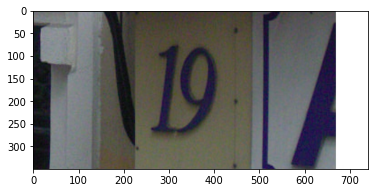

In [13]:
# display an image

img = 'RawData/train/1.png'
image = mpimg.imread(img)
plt.imshow(image)
plt.show()

In [14]:
# define a function for displaying the images with bounding boxes

def show_bboxes(img, file, bboxes, idx):
    data = get_image_boxes(file, bboxes, idx)
    fig, ax = plt.subplots()
    image = mpimg.imread(img) 
    for i in range(len(data['top'])):   
        ax.add_patch(Rectangle((data['left'][i], data['top'][i]), data['width'][i], data['height'][i],
                           linewidth=1, edgecolor='b', facecolor='none'))
    image = ax.imshow(image)
    return image

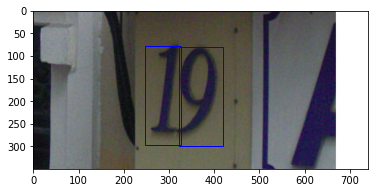

In [15]:
img = 'RawData/train/1.png'

show_bboxes(img, train, train_bbox, 0)

In [16]:
# define a function to merge the bounding boxes into one

def merge_boxes(file, bboxes, idx):
    data = get_image_boxes(file, bboxes, idx)
    left = min(data['left'])
    top = min(data['top'])
    width = max(map(add, data['left'], data['width'])) - left
    height = max(map(add, data['top'], data['height'])) - top
    labels = [x if x != 10 else 0 for x in data['label']]
    b_box = {'left': left, 'top': top, 'width': width, 'height': height, 'labels': labels}
    return b_box

In [17]:
merge_boxes(train, train_bbox, 0)

{'left': 246, 'top': 77, 'width': 173, 'height': 223, 'labels': [1, 9]}

In [18]:
def process(file, bboxes, labels):
    data = {}
    num = file['digitStruct/name'].shape[0]
    for idx in range(num):
        b_box = merge_boxes(file, bboxes, idx)
        fname = get_image_label(file, labels, idx)
        data[fname] = b_box
    return data

In [19]:
train_data = process(train, train_bbox, train_labels)
test_data = process(test, test_bbox, test_labels)

In [20]:
def pickle_it(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, -1)

In [21]:
pickle_it(train_data, 'train.pkl')
pickle_it(test_data, 'test.pkl')

In [22]:
path = os.getcwd()
train_path = os.path.join(path, 'RawData/train')
train_metafile = os.path.join(train_path, 'digitStruct.mat')
train_file = h5py.File(train_metafile, 'r')
test_path = os.path.join(path, 'RawData/test')
test_metafile = os.path.join(test_path, 'digitStruct.mat')
test_file = h5py.File(test_metafile, 'r')

In [23]:
train_data = os.path.join(path, 'train.pkl')
test_data = os.path.join(path, 'test.pkl')

In [24]:
dbfile = open("train.pkl", 'rb')

In [25]:
data = pickle.load(dbfile)

{'height': [33], 'left': [56], 'top': [12], 'width': [22], 'label': [7]}


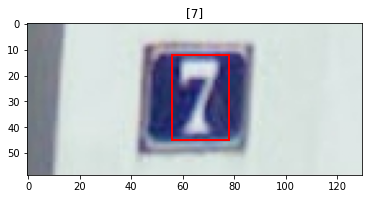

{'height': [63, 63], 'left': [72, 92], 'top': [17, 20], 'width': [21, 15], 'label': [3, 1]}


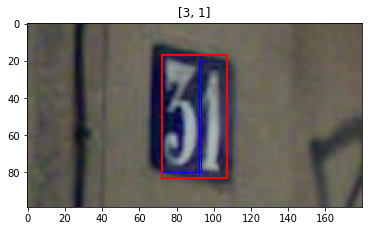

{'height': [84, 84], 'left': [62, 112], 'top': [0, 7], 'width': [54, 57], 'label': [7, 2]}


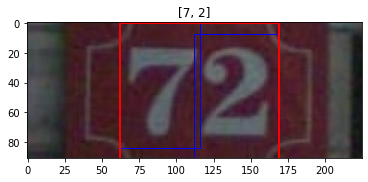

{'height': [16, 16, 16], 'left': [14, 20, 29], 'top': [1, 1, 1], 'width': [8, 10, 11], 'label': [1, 2, 8]}


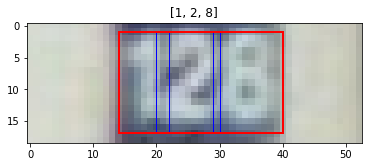

{'height': [19, 19], 'left': [25, 36], 'top': [4, 7], 'width': [5, 5], 'label': [1, 1]}


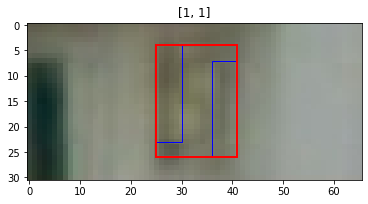

{'height': [38, 38, 38], 'left': [58, 70, 84], 'top': [15, 12, 12], 'width': [13, 12, 13], 'label': [2, 6, 8]}


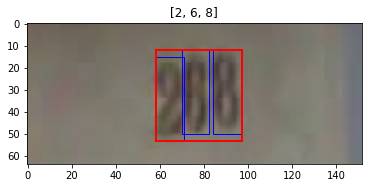

{'height': [18], 'left': [33], 'top': [9], 'width': [7], 'label': [4]}


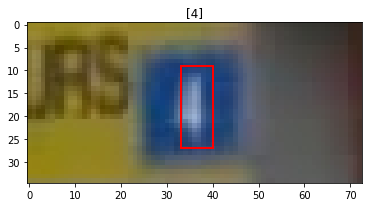

{'height': [19], 'left': [45], 'top': [16], 'width': [5], 'label': [1]}


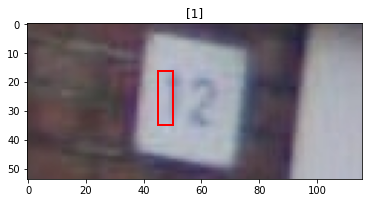

{'height': [21], 'left': [19], 'top': [1], 'width': [12], 'label': [5]}


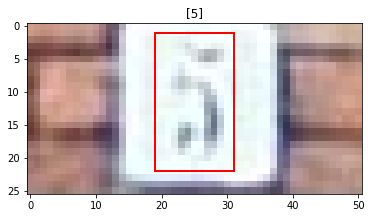

{'height': [46, 46, 46], 'left': [56, 82, 107], 'top': [8, 12, 4], 'width': [17, 22, 23], 'label': [1, 10, 1]}


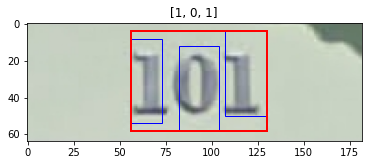

In [26]:
file = train
bboxes = train_bbox


for _ in range(10):
    idx = random.randint(1, len(data))
    fn = '{}{}'.format(idx, '.png')
    # Display image
    x = data[fn]['left']
    y = data[fn]['top']
    w = data[fn]['width']
    h = data[fn]['height']
    img_f = os.path.join(train_path, fn)
    img = mpimg.imread(img_f)
    fig, ax = plt.subplots(1)

    # Draw individual bounding boxes
    meta = get_image_boxes(file, bboxes, idx-1)
    print(meta)
    for i in range(len(meta['top'])):
        ax.add_patch(Rectangle((meta['left'][i], meta['top'][i]),
                                meta['width'][i], meta['height'][i],
                                linewidth=1, edgecolor='b', facecolor='none'))

    # Draw the outer bounding box
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.imshow(img)
    plt.title(data[fn]['labels'])
    plt.show()

## Define functions for processing the bounding box data to csv

In [27]:
# define a function to convert the image data to dataframe

def dict_to_df(file, labels, bboxes):
    box_list = []
    data_length = length(file)
    idx = 0
    while idx in range(data_length):
        fn = get_image_label(file, labels, idx)
        bbox = get_image_boxes(file, bboxes, idx)
        box_list.append({'filename': fn,
                          'label': bbox['label'],
                          'width': bbox['width'],
                          'height': bbox['height'],
                          'top': bbox['top'],
                          'left': bbox['left']})
        idx+=1
    return pd.DataFrame(box_list)

In [28]:
train_df = dict_to_df(train, train_labels, train_bbox)

In [36]:
train_df.shape

(33402, 6)

In [76]:
train_df.head(3)

,filename,label,width,height,top,left,digitCount
0,1.png,"[1, 9]","[81, 96]","[219, 219]","[77, 81]","[246, 323]",2
1,2.png,"[2, 3]","[23, 26]","[32, 32]","[29, 25]","[77, 98]",2
2,3.png,"[2, 5]","[8, 9]","[15, 15]","[5, 5]","[17, 25]",2


In [30]:
test_df = dict_to_df(test, test_labels, test_bbox)

In [37]:
test_df.shape

(13068, 6)

In [77]:
test_df.head(3)

,filename,label,width,height,top,left,digitCount
0,1.png,[5],[19],[30],[7],[43],1
1,2.png,"[2, 1, 10]","[14, 8, 12]","[23, 23, 23]","[5, 8, 6]","[99, 114, 121]",3
2,3.png,[6],[11],[16],[6],[61],1


In [32]:
train_df.to_csv('RawData/csv/train_bboxes.csv', index=False)
test_df.to_csv('RawData/csv/test_bboxes.csv', index=False)

In [70]:
def label_len(df):
    digitCount = []
    i=0
    while i in range(len(df)):
        digitCount.append(len(df.iloc[i,1]))
        i+=1
    return digitCount

In [73]:
train_df['digitCount'] = label_len(train_df)

In [78]:
train_df.head(3)

,filename,label,width,height,top,left,digitCount
0,1.png,"[1, 9]","[81, 96]","[219, 219]","[77, 81]","[246, 323]",2
1,2.png,"[2, 3]","[23, 26]","[32, 32]","[29, 25]","[77, 98]",2
2,3.png,"[2, 5]","[8, 9]","[15, 15]","[5, 5]","[17, 25]",2


In [75]:
test_df['digitCount'] = label_len(test_df)

In [79]:
test_df.head(3)

,filename,label,width,height,top,left,digitCount
0,1.png,[5],[19],[30],[7],[43],1
1,2.png,"[2, 1, 10]","[14, 8, 12]","[23, 23, 23]","[5, 8, 6]","[99, 114, 121]",3
2,3.png,[6],[11],[16],[6],[61],1


In [82]:
# drop rows with more than 5 digits

train_df = train_df[train_df['digitCount']<6]

In [ ]:
# define paths for the data

path = os.getcwd()
train_path = os.path.join(path, 'RawData/train')
test_path = os.path.join(path, 'RawData/test')